Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Embedding, Conv1D, Dense, GlobalMaxPooling1D, Input, Average
from IPython.display import clear_output

Load data

In [42]:

df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [43]:
df.shape

(5572, 2)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [45]:
df['label'].value_counts() # the ham is 6.45 more than the spam

label
ham     4825
spam     747
Name: count, dtype: int64

<Axes: title={'center': 'Data distribution'}>

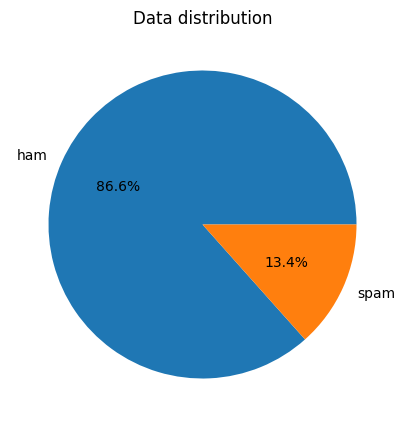

In [46]:
df['label'].value_counts().plot(kind='pie', figsize=(5, 5),title='Data distribution',ylabel='',autopct='%1.1f%%')

will handel the data imbalance in the training phase

In [47]:
total_count=df.shape[0]
ham_count=df['label'].value_counts()[0]
spam_count=df['label'].value_counts()[1]
clear_output()
print(f'total count is: {total_count}\nham count is: {ham_count}\nspam count is: {spam_count}')


total count is: 5572
ham count is: 4825
spam count is: 747


Encode labels

In [48]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


Clean text

In [49]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Keep only letters
    return text

df['text'] = df['text'].apply(clean_text)
df

,label,text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,1,this is the nd time we have tried contact u u...
5568,0,will b going to esplanade fr home
5569,0,pity was in mood for that soany other suggest...
5570,0,the guy did some bitching but i acted like id ...


Tokenization

In [50]:
tokenizer = Tokenizer(num_words=8000) # use top 8000 words
tokenizer.fit_on_texts(df['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['text'])
padded_sequences = pad_sequences(sequences, maxlen=100)
print(sequences,'\n'*5,padded_sequences)

[[44, 440, 3938, 774, 697, 667, 62, 8, 1213, 87, 118, 347, 1009, 150, 2692, 1214, 65, 56, 3939, 135], [47, 308, 1354, 441, 6, 1753], [46, 457, 8, 4, 733, 874, 1, 179, 1754, 1010, 611, 1755, 233, 261, 69, 1754, 1, 1, 309, 457, 2693, 77, 2694, 364, 2695], [6, 228, 141, 23, 348, 2696, 6, 154, 142, 58, 141], [928, 2, 42, 96, 70, 458, 1, 875, 70, 1756, 199, 109, 459], [821, 119, 65, 1529, 40, 98, 585, 21, 7, 37, 335, 85, 349, 54, 104, 380, 3, 41, 12, 15, 83, 1757, 47, 350, 1011, 3940, 1, 68, 1, 1758], [200, 11, 586, 9, 24, 54, 1, 351, 33, 10, 107, 668, 10, 54, 3941, 3942], [71, 207, 13, 1101, 1355, 1355, 1759, 2091, 2092, 2093, 110, 98, 562, 71, 13, 929, 12, 49, 1530, 775, 1, 1012, 13, 216, 929], [669, 71, 4, 776, 409, 217, 3, 17, 98, 410, 1, 2697, 138, 930, 1, 113, 16, 113, 396, 2698, 499, 519, 62], [128, 13, 90, 670, 26, 122, 6, 82, 1102, 1, 484, 1, 5, 301, 540, 822, 33, 324, 12, 46, 16, 5, 90, 484, 1215, 46, 18], [22, 218, 31, 78, 208, 7, 2, 42, 67, 1, 263, 75, 39, 277, 1103, 209, 151, 1

demonstration for the tokenization of the text

In [51]:
print(df['text'][0])
print(sequences[0])
for w in df['text'][0].split():
    print(w,':',word_index[w],end=' ')        

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
[44, 440, 3938, 774, 697, 667, 62, 8, 1213, 87, 118, 347, 1009, 150, 2692, 1214, 65, 56, 3939, 135]
go : 44 until : 440 jurong : 3938 point : 774 crazy : 697 available : 667 only : 62 in : 8 bugis : 1213 n : 87 great : 118 world : 347 la : 1009 e : 150 buffet : 2692 cine : 1214 there : 65 got : 56 amore : 3939 wat : 135 

Split data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df['label'], test_size=0.2, random_state=42
)
print('train:', X_train.shape, 'test:', X_test.shape)
print('train:', y_train.shape, 'test:', y_test.shape)

train: (4457, 100) test: (1115, 100)
train: (4457,) test: (1115,)


Define vocabulary size, max sequence length and Embedding dimentions

In [53]:
VOCAB_SIZE = len(word_index) 
MAX_LENGTH = 100        # the same as padding length
EMBEDDING_DIM = 300     # GloVe, Word2Vec, and FastText use 300D

Define input layer

In [54]:
input_layer = Input(shape=(MAX_LENGTH,))
clear_output()

NETWORK STRUCTURE

In [57]:
# function to read the glove weights 
def load_glove_embeddings(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create embedding matrix for tokenizer's vocabulary
    embedding_matrix = np.random.randn(VOCAB_SIZE, EMBEDDING_DIM) * 0.1  # Initialize the word vector randomly
    for word, i in word_index.items():
        if i >= VOCAB_SIZE:  #comment for testing the whole vocab
            continue  # Skip words beyond `num_words`
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Replace with GloVe vector
    return embedding_matrix


# function to read the word2vec weights 
from gensim.models import KeyedVectors
def load_word2vec_embeddings(word2vec_file_path):
    word2vec_model = KeyedVectors.load_word2vec_format(word2vec_file_path, binary=True)
    embedding_matrix = np.random.randn(VOCAB_SIZE, EMBEDDING_DIM) * 0.1
    for word, i in word_index.items():
        if i >= VOCAB_SIZE:    #commented for testing the whole vocab
            continue
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    return embedding_matrix

# function to read the word2vec weights 
def load_fasttext_embeddings(fasttext_file_path):
    embeddings_index = {}
    with open(fasttext_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.random.randn(VOCAB_SIZE, EMBEDDING_DIM) * 0.1
    for word, i in word_index.items():
        if i >= VOCAB_SIZE:     #commented for testing the whole vocab
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

Transfer Learning Layer: Pre-trained Embedding (GloVe)

In [58]:
embedding_matrix_1= load_glove_embeddings('glove.6B.300d.txt') # path of glove
embedding_1 = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,  # GloVe dimension
    weights=[embedding_matrix_1],  # Load pre-trained weights
    trainable=False  # Freeze embeddings (transfer learning)
)(input_layer)

CNN Layer for GloVe

In [59]:
# Detects local patterns (e.g., "free", "win")
conv1 = Conv1D(
    filters=64,
    kernel_size=3,
    activation='relu',
    name='conv1'
)(embedding_1)
pool1 = GlobalMaxPooling1D()(conv1)  # Extract strongest activation

Transfer Learning Layer: Pre-trained Embedding (Word2Vec)

In [60]:
embedding_matrix_2=load_word2vec_embeddings('GoogleNews-vectors-negative300.bin') # path of word2vec

embedding_2 = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_2],  # Load Word2Vec weights
    trainable=False
)(input_layer)

CNN Layer for word2vec

In [61]:
# Detects local patterns (e.g., "free", "win")
conv2 = Conv1D(
    filters=64,
    kernel_size=4,  # Different kernel size to capture varied patterns
    activation='relu',
    name='conv2'
)(embedding_2)
pool2 = GlobalMaxPooling1D()(conv2)

Transfer Learning Layer: Pre-trained Embedding (FastText)

In [62]:
embedding_matrix_3=load_fasttext_embeddings('wiki-news-300d-1M.vec')#path of fasttext

embedding_3 = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix_3],  # Load FastText weights
    trainable=False
)(input_layer)

CNN Layer for Fasttext

In [63]:
conv3 = Conv1D(
    filters=64,
    kernel_size=5,  # Larger kernel for longer phrases
    activation='relu',
    name='conv3'
)(embedding_3)
pool3 = GlobalMaxPooling1D()(conv3)

Voting Mechanism: Average predictions

In [64]:
dense1 = Dense(1, activation='sigmoid', name='vote1')(pool1)
dense2 = Dense(1, activation='sigmoid', name='vote2')(pool2)
dense3 = Dense(1, activation='sigmoid', name='vote3')(pool3)

# Average the three predictions
final_output = Average(name='final_vote')([dense1, dense2, dense3])
clear_output()

Model Build

In [66]:
model = Model(inputs=input_layer, outputs=final_output)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)
clear_output()

Training With Regularization

In [69]:
# will use The Inverse Class Frequency Method to handle the imbalance
ham_weight= total_count/(ham_count*2)
spam_weight= total_count/(spam_count*2)
clear_output()
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    class_weight={0: ham_weight, 1: spam_weight}  # Handle class imbalance
)
# Evaluate
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}")

Epoch 1/10
112/112 [==============================] - 4s 33ms/step - loss: 0.0058 - accuracy: 0.9989 - precision_1: 0.9937 - recall_1: 0.9979 - val_loss: 0.0560 - val_accuracy: 0.9798 - val_precision_1: 0.9565 - val_recall_1: 0.8943
Epoch 2/10
112/112 [==============================] - 2s 22ms/step - loss: 0.0051 - accuracy: 0.9992 - precision_1: 0.9937 - recall_1: 1.0000 - val_loss: 0.0571 - val_accuracy: 0.9821 - val_precision_1: 0.9735 - val_recall_1: 0.8943
Epoch 3/10
112/112 [==============================] - 2s 15ms/step - loss: 0.0046 - accuracy: 0.9992 - precision_1: 0.9937 - recall_1: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9821 - val_precision_1: 0.9735 - val_recall_1: 0.8943
Epoch 4/10
112/112 [==============================] - 2s 16ms/step - loss: 0.0040 - accuracy: 0.9994 - precision_1: 0.9958 - recall_1: 1.0000 - val_loss: 0.0579 - val_accuracy: 0.9821 - val_precision_1: 0.9735 - val_recall_1: 0.8943
Epoch 5/10
112/112 [==============================] - 2s 15ms/step -

Plot Training history

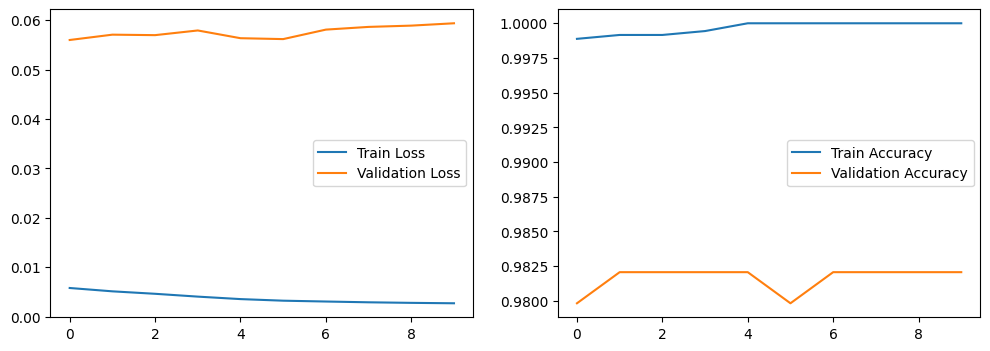

In [70]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()